In [1]:
import requests
import zipfile
import os
import torch
from tqdm import trange,tqdm
import torch.nn as nn
import torch.optim as optim
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from csv import reader
cur_device = "cuda"

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# download UCI power consumption dataset from website
URL = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00235/household_power_consumption.zip'
response = requests.get(URL)
open('household_power_consumption.zip', 'wb').write(response.content)
with zipfile.ZipFile('household_power_consumption.zip','r') as zip_ref:
    zip_ref.extractall(os.getcwd())
os.remove('household_power_consumption.zip')
# remove the first line from the txt file corresponding to column titles
with open('household_power_consumption.txt', 'r') as fin:
    data = fin.read().splitlines(True)
with open('household_power_consumption.txt', 'w') as fout:
    fout.writelines(data[1:])

In [3]:
# replace semicolons with commas in the downloaded text file
with open('household_power_consumption.txt', 'r') as file :
    filedata = file.read()
filedata = filedata.replace(';', ',')
with open('household_power_consumption.txt', 'w') as file:
    file.write(filedata)

# read data into a list of lists
with open('household_power_consumption.txt', 'r') as read_obj:
    csv_reader = reader(read_obj)
    list_of_rows = list(csv_reader)
    
# append first two columns (date + time)
list_of_rows = [[x[0]+','+x[1]]+x[2:] for x in list_of_rows]

In [4]:
# get datetime object of first entr
init_time = list_of_rows[0][0] # initial time for dataset
init_time_obj = datetime.strptime(init_time,"%d/%m/%Y,%H:%M:%S")

# rewrite list in terms of time deltas in seconds
list_of_rows = [[(datetime.strptime(x[0],"%d/%m/%Y,%H:%M:%S")-init_time_obj).total_seconds()]+x[1:] for x in list_of_rows]

# convert to numpy
data = np.array(list_of_rows)

In [5]:
# extract data for all three submeterings
X_sm_1 = data[:,5]
X_sm_2 = data[:,6]
X_sm_3 = data[:,7]

In [6]:
# sort data into X_train and y_train
in_size = 10
out_size = 5
X_sm_1_list = list(X_sm_1)
for i in tqdm(range(X_sm_1.shape[0]-in_size-out_size)):
    if i == 0:
        X_train = [X_sm_1[i:in_size]]
        Y_train = [X_sm_1[i+in_size:i+in_size+out_size]]
    else:
        X_train.append(X_sm_1[i:i+in_size])
        Y_train.append(X_sm_1[i+in_size:i+in_size+out_size])
X_train = np.array(X_train)
Y_train = np.array(Y_train)
X_train[X_train=='?'] = 0
Y_train[Y_train=='?'] = 0
X_train[X_train==''] = 0
Y_train[Y_train==''] = 0

100%|██████████| 2075244/2075244 [00:00<00:00, 2516566.39it/s]


In [7]:
# try a simple sequential model first
seq_model = nn.Sequential(
    nn.Linear(in_size,5*in_size),
    nn.Tanh(),
    nn.Linear(5*in_size,3*out_size),
    nn.PReLU(),
    nn.Linear(3*out_size,out_size)
)

In [8]:
optimizer = optim.SGD(seq_model.parameters(), lr=1e-3)
n_epochs = 20000
loss_fn = nn.MSELoss()
losses = []
BS = 512
device = torch.device(cur_device)
X_train_t = torch.from_numpy(X_train.astype(np.float32)).to(device)
Y_train_t = torch.from_numpy(Y_train.astype(np.float32)).to(device)
seq_model = seq_model.to(device)

for i in (t:=trange(n_epochs)):
    samp = np.random.randint(0,X_train.shape[0],(BS))
    X = X_train_t[samp,:]
    Y = Y_train_t[samp]
    out = seq_model(X)
    loss = loss_fn(out,Y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    t.set_description('loss %.3f' % (loss.item()))
    losses.append(loss.item())

  0%|          | 0/20000 [00:00<?, ?it/s]


NotImplementedError: The operator 'aten::index.Tensor' is not current implemented for the MPS device. If you want this op to be added in priority during the prototype phase of this feature, please comment on https://github.com/pytorch/pytorch/issues/77764. As a temporary fix, you can set the environment variable `PYTORCH_ENABLE_MPS_FALLBACK=1` to use the CPU as a fallback for this op. WARNING: this will be slower than running natively on MPS.

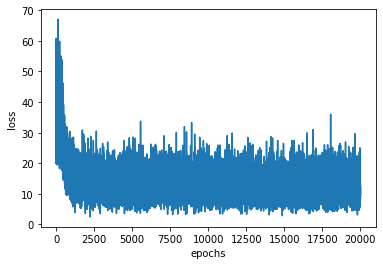

In [ ]:
# loss plot
plt.plot(losses)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

100%|██████████| 10/10 [00:00<00:00, 10022.23it/s]


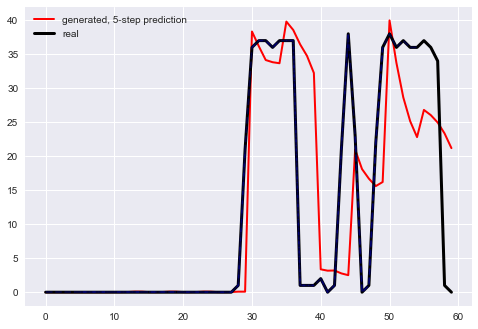

In [ ]:
# Reconstruct a specific part of the train data using trained NN
n_reconstruction = 10
n_offset = 71000
X_sm_1[X_sm_1=='?'] = 0
X_sm_1 = X_sm_1.reshape((X_sm_1.shape[0],1)).astype(np.float32)
for i in (t:=trange(n_reconstruction)):
    inp = X_sm_1[n_offset+out_size*i:n_offset+in_size+out_size*i,:].T
    inp_idx = np.array([[x for x in range(out_size*i,in_size+out_size*i)]])
    next = X_sm_1[n_offset+in_size+out_size*i:n_offset+in_size+out_size*(i+1),:]
    if i == 0:
        out = seq_model(torch.from_numpy(inp)).detach().numpy()
        gen_data = np.hstack((inp,out[0,:out_size].reshape((1,out_size))))
        real_data = np.hstack((inp,next.reshape((1,out_size))))
        InpStack = inp
        InpIdxStack = inp_idx
    else:
        out = seq_model(torch.from_numpy(inp)).detach().numpy()
        gen_data = np.hstack((gen_data,out[0,:out_size].reshape((1,out_size))))
        real_data = np.hstack((real_data,next.reshape((1,out_size))))
        InpStack = np.vstack((InpStack,inp))
        InpIdxStack = np.vstack((InpIdxStack,inp_idx))
# plot
mpl.style.use('seaborn')
plt.plot(gen_data.reshape((gen_data.shape[1],)),"r",linewidth=2)
plt.plot(real_data.reshape((real_data.shape[1],)),"k",linewidth=3)
plt.plot(InpIdxStack.T,InpStack.T,"b--",alpha=0.25)
plt.legend(['generated, 5-step prediction','real'])
plt.show()   

In [ ]:
[x for x in range(3,4)]

[3]